# Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/UET/Computational Neuroscience/Personal"

/content/drive/MyDrive/UET/Computational Neuroscience/Personal


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn as sk
from sklearn.decomposition import PCA
from scipy.signal import butter, lfilter

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

## Load data

In [5]:
import scipy.io

def load_data(sample_1):
    # Load the .mat file using scipy.io.loadmat
    mat = scipy.io.loadmat(sample_1)

    # Extract the data and ground truth spike samples and clusters
    data = mat['data'].T  # Assuming 'data' is a key in your .mat file

    # Ground truth data extraction from .mat file
    true_spike_samp = mat['spike_times'][0][0].T
    true_spike_samp = true_spike_samp.reshape(len(true_spike_samp), )

    true_spike_cluster = mat['spike_class'][0][0].T
    true_spike_cluster = true_spike_cluster.reshape(len(true_spike_cluster), )

    return data, true_spike_samp, true_spike_cluster

rate = 24000  # Sampling rate in Hz

# Now call the load_data function with the correct file path
data, true_spike_samp, true_spike_cluster = load_data('./sample_1.mat')
print(data.shape)

(2880000, 1)


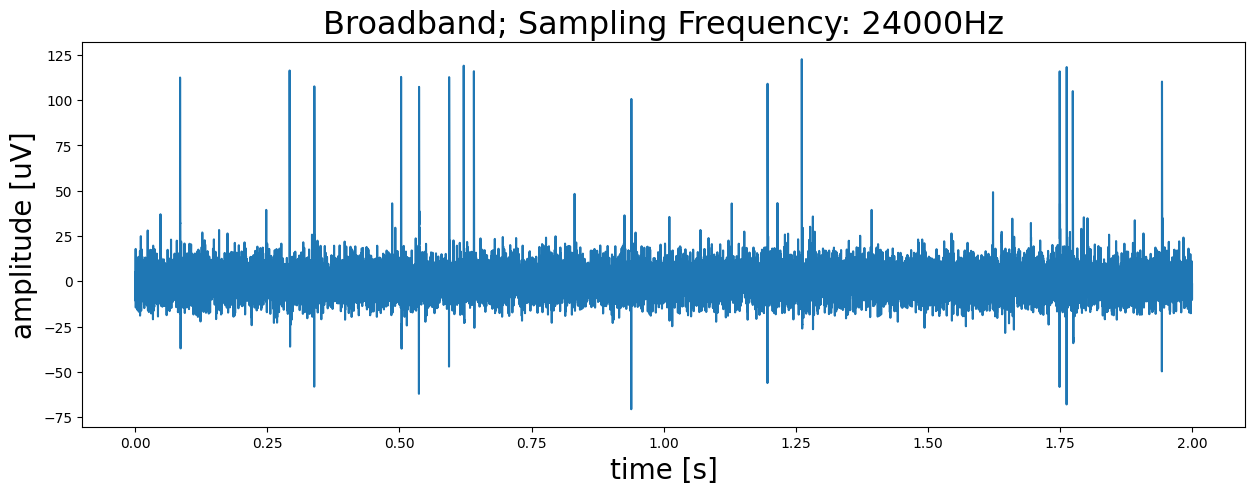

In [6]:
def vis_data(data, rate, start, stop, scl=3):
    N = data.shape[0]  # Num. of samples

    # Determine duration of recording in seconds
    duration = N / rate

    # Create time vector
    time = np.linspace(0, duration, N)

    # Create mask for the specified time interval
    mask = (time >= start) & (time < stop)

    # Plot data in seconds
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(time[mask], data[mask])
    ax.set_title('Broadband; Sampling Frequency: {}Hz'.format(rate), fontsize=23)
    ax.set_xlabel('time [s]', fontsize=20)
    ax.set_ylabel('amplitude [uV]', fontsize=20)

    plt.show()

# Visualize data within a given time interval in sec
vis_data(data, rate, start=0.0, stop=2, scl=3.50)

In [7]:
def plot_spikes(wave_form, spike_window, spike_samp, name="real"):
    # Plot a graph with spikes overlapped and aligned at the max. value
    np.random.seed(11)
    fig, ax = plt.subplots(figsize=(15, 6))

    # Select 100 random spikes for plotting
    selected_spikes = np.random.choice(wave_form.shape[0], 100, replace=False)

    # Use a color gradient for the spikes
    colors = plt.cm.viridis(np.linspace(0, 1, 100))

    for i, spike in enumerate(selected_spikes):
        ax.plot(wave_form[spike, :], color=colors[i], alpha=0.7, linewidth=0.8)

    # Highlight the average waveform of the selected spikes
    avg_waveform = np.mean(wave_form[selected_spikes, :], axis=0)
    ax.plot(avg_waveform, color='black', linewidth=2, label='Average Waveform')

    # Annotate the peak of the average waveform
    peak_idx = np.argmax(avg_waveform)
    ax.annotate('Peak', xy=(peak_idx, avg_waveform[peak_idx]), xytext=(peak_idx + 5, avg_waveform[peak_idx] + 5),
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

    # Add a grid for better visual aid
    ax.grid(True, linestyle='--', alpha=0.5)

    # Customizing axes
    ax.set_xlim([0, spike_window * 2])
    ax.set_xticks(np.linspace(0, spike_window * 2, 9))  # Custom x-ticks
    ax.set_xlabel('# of samples', fontsize=18)
    ax.set_ylabel('Amplitude [uV]', fontsize=18)
    ax.set_title('100 Random Spike Waveforms\n{} {} Spikes '.format(len(spike_samp), name), fontsize=22)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

## Get real spikes

In [8]:
def get_real_spikes(spike_window, indices, data, name="real"):
    table_spikes_found=[]
    waveform_final = np.empty([1, spike_window*2])

    print(data.shape)

    for i in range(len(indices)):
        #Itereate over the next 45 consecutive samples and detect if match with spikes extracted exists
        tmp_waveform = data[indices[i] : indices[i]+spike_window]
        tmp_samp = np.argmax(tmp_waveform) + indices[i]
        tmp_waveform_new = data[tmp_samp - (spike_window):tmp_samp + (spike_window)]

        # print(tmp_samp)
        # print(indices[i])
        # print(tmp_samp - (spike_window))
        # print(tmp_samp + (spike_window))
        # print(tmp_waveform.shape)

        table_spikes_found = np.append(table_spikes_found, tmp_samp)
        waveform_final = np.append(waveform_final, tmp_waveform_new.reshape(1, spike_window*2), axis=0)

    waveform_final = np.delete(waveform_final, (0), axis=0)

    plot_spikes(waveform_final, spike_window, table_spikes_found, name)

    return table_spikes_found, waveform_final

(2880000, 1)


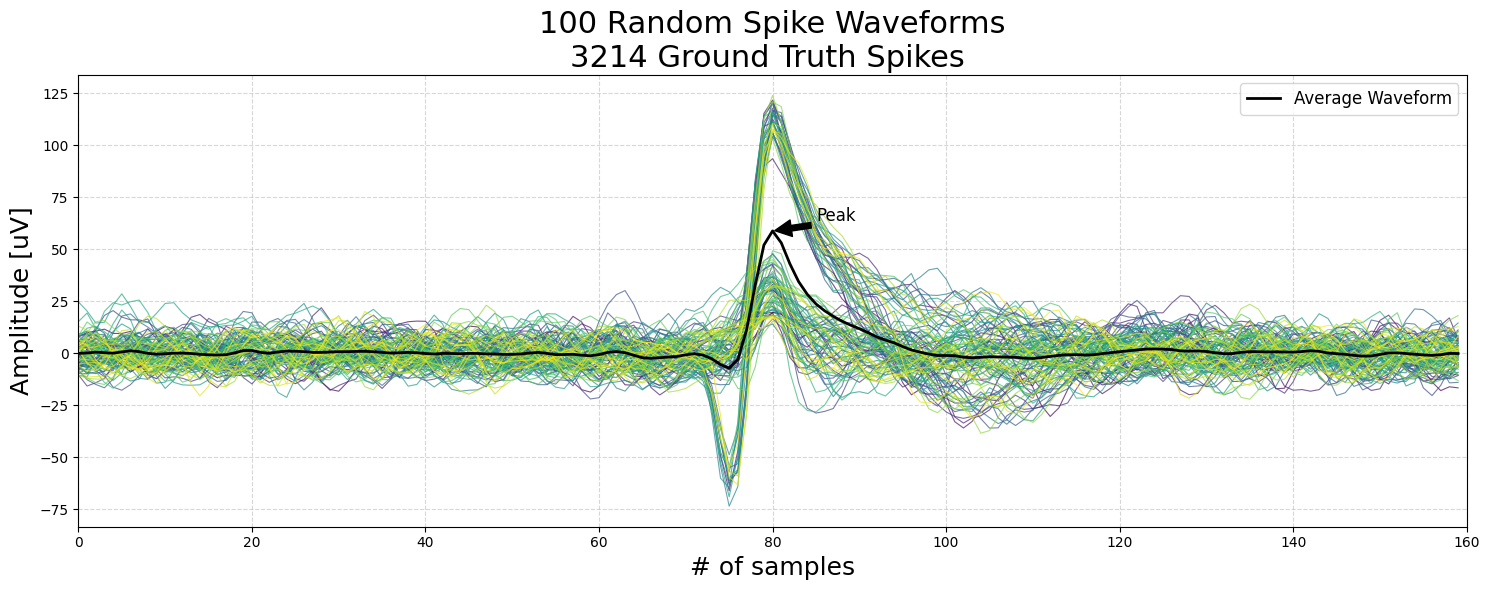

In [9]:
real_spike_samp, real_waveform = get_real_spikes(80, true_spike_samp, data, name="Ground Truth")

In [10]:
# Apply min-max scaling
scaler = sk.preprocessing.MinMaxScaler()
dataset_real_scaled = scaler.fit_transform(real_waveform)
print(real_waveform.shape)

(3214, 160)


## Get detected spikes

(1, 160)


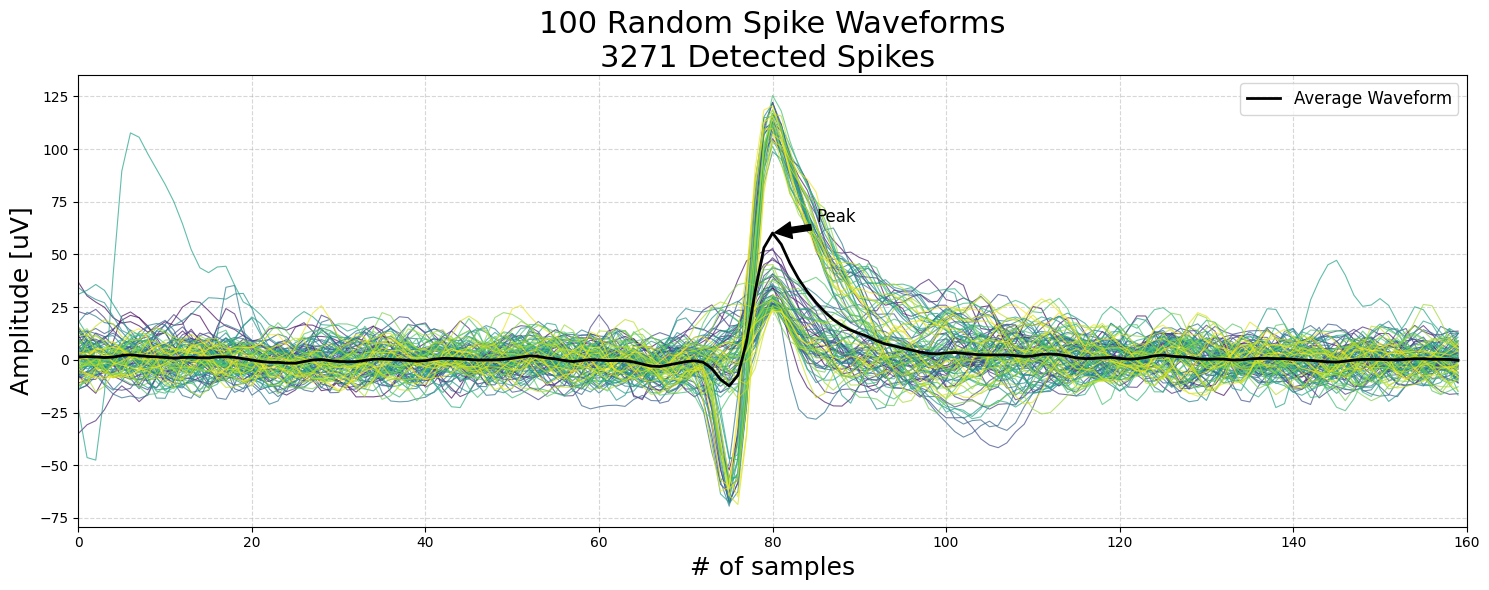

3271 spikes detected


In [11]:
def get_spikes(data, spike_window=80, scl=5, offset=10, min_spike_dst=50, max_thresh=350, name="real"):

    # Calculate threshold based on Median Absolute Deviation
    thresh = np.median(np.abs(data - np.median(np.abs(data)))) * scl

    # Find samples where the threshold is crossed for the first time
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]  # Remove values that do not have enough space for window to their left
    ind = np.diff(pos)             # 1 --> next value is consecutive, otherwise non-consecutive

    # print(ind)

    # raise ValueError("DEBUG")

    idx = []    # Initialize array that will contain all starting samples for spike detection
    consecutive = False
    for i in range(len(ind)):
        if (ind[i] == 1) & (consecutive == False):
            # Append new sample only if it is the first to go over threshold
            idx = np.append(idx, pos[i]).astype(int)
            consecutive = True
        elif ind[i] > min_spike_dst:
            consecutive = False

    # Extract spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])

    print(wave_form.shape)
    for i in idx:
        if i < data.shape[0] - (spike_window + 1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i + min_spike_dst]

            #print(tmp_waveform.shape)

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) + i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp - (spike_window - offset):tmp_samp + (spike_window + offset)]
                # Append data
                spike_samp = np.append(spike_samp, tmp_samp).astype(int)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)

                # print(wave_form.shape)

            #raise ValueError("DEBUG")

    wave_form = np.delete(wave_form, (0), axis=0)  # Remove first empty row

    plot_spikes(wave_form, spike_window, spike_samp, name)

    print('{} spikes detected'.format(len(spike_samp)))

    return spike_samp, wave_form

# Extract spikes and visualize 100 random samples
spike_samp, wave_form = get_spikes(data, spike_window=80, scl=3.65, offset=0, min_spike_dst=50, name="Detected")

In [12]:
# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)
print(wave_form.shape)

(3271, 160)


# Model

## PCA

In [13]:
#PCA

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def pca(data, threshold=0.95, name="real"):
    # Finds explained variance
    pca = PCA().fit(data)

    fig, ax = plt.subplots(1, 2, figsize=(28, 8))

    ax[0].plot(np.cumsum(pca.explained_variance_ratio_), color='darkblue', linewidth=2)
    ax[0].set_title('Explained Variance by Number of Components', fontsize=18)
    ax[0].set_xlabel('Number of Components', fontsize=14)
    ax[0].set_ylabel('Cumulative Explained Variance', fontsize=14)
    ax[0].grid(True, linestyle='--', alpha=0.7)

    # extract n_components with 95% variance
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1

    # Draw vertical line at 48
    ax[0].axvline(x=n_components, color='red', linestyle='--', linewidth=2)

    # Draw horizontal line at the intersection
    cumulative_variance_95 = np.cumsum(pca.explained_variance_ratio_)[n_components]
    ax[0].axhline(y=cumulative_variance_95, color='green', linestyle='--', linewidth=2)
    ax[0].annotate(f'{cumulative_variance_95:.2f}',
                xy=(n_components, cumulative_variance_95),
                xytext=(n_components+2, cumulative_variance_95 + 0.05),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, color='black')

    # Do PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    # Plot the 1st principal component against the 2nd and use the 3rd for color
    sc = ax[1].scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2], cmap='plasma', s=50, alpha=0.7)

    # Add labels and title
    ax[1].set_xlabel('1st Principal Component', fontsize=16)
    ax[1].set_ylabel('2nd Principal Component', fontsize=16)
    ax[1].set_title(f'1st vs 2nd Principal Component of {n_components} components, colored by 3rd', fontsize=20)

    # Add colorbar
    cbar = fig.colorbar(sc)
    cbar.set_label('3rd Principal Component', fontsize=14)

    # Improve readability by adding grid
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # Adjust subplot spacing
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(f"PCA on {name} spikes", fontsize=20)
    plt.show()

    return n_components, pca_result

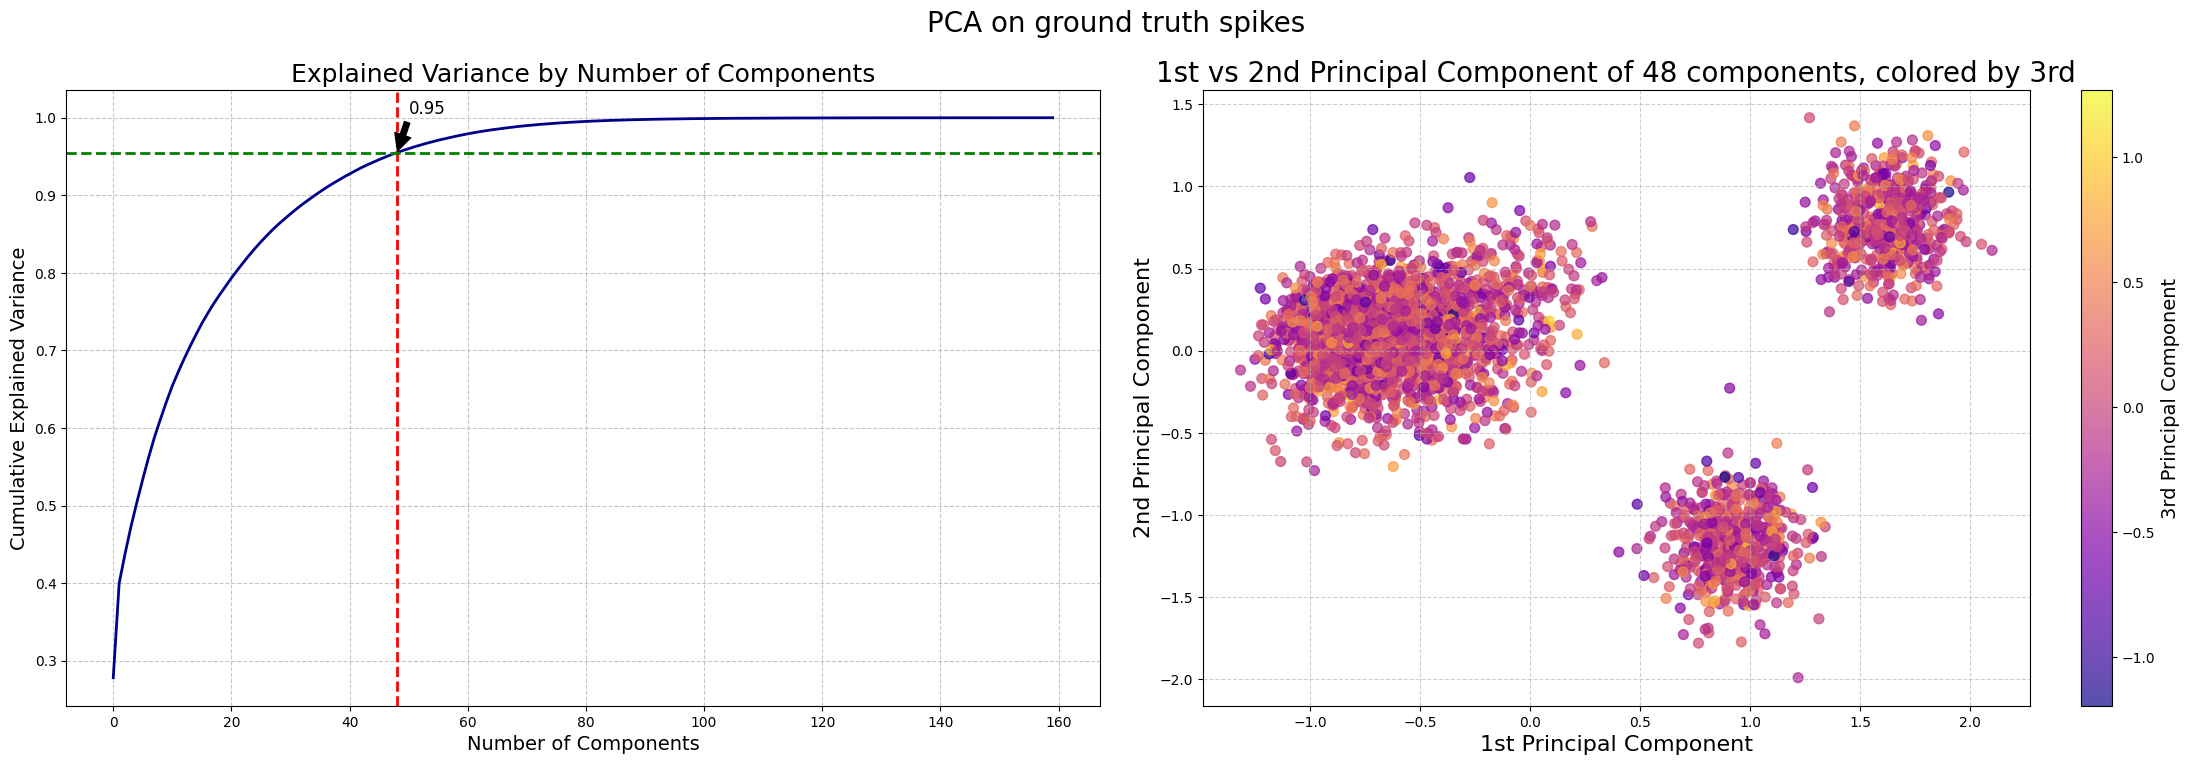

(3214, 48)
48
(3214, 160)


In [14]:
# Extracted data
n_components_real, pca_result_real = pca(dataset_real_scaled, name="ground truth")
print(pca_result_real.shape)
print(n_components_real)
print(dataset_real_scaled.shape)

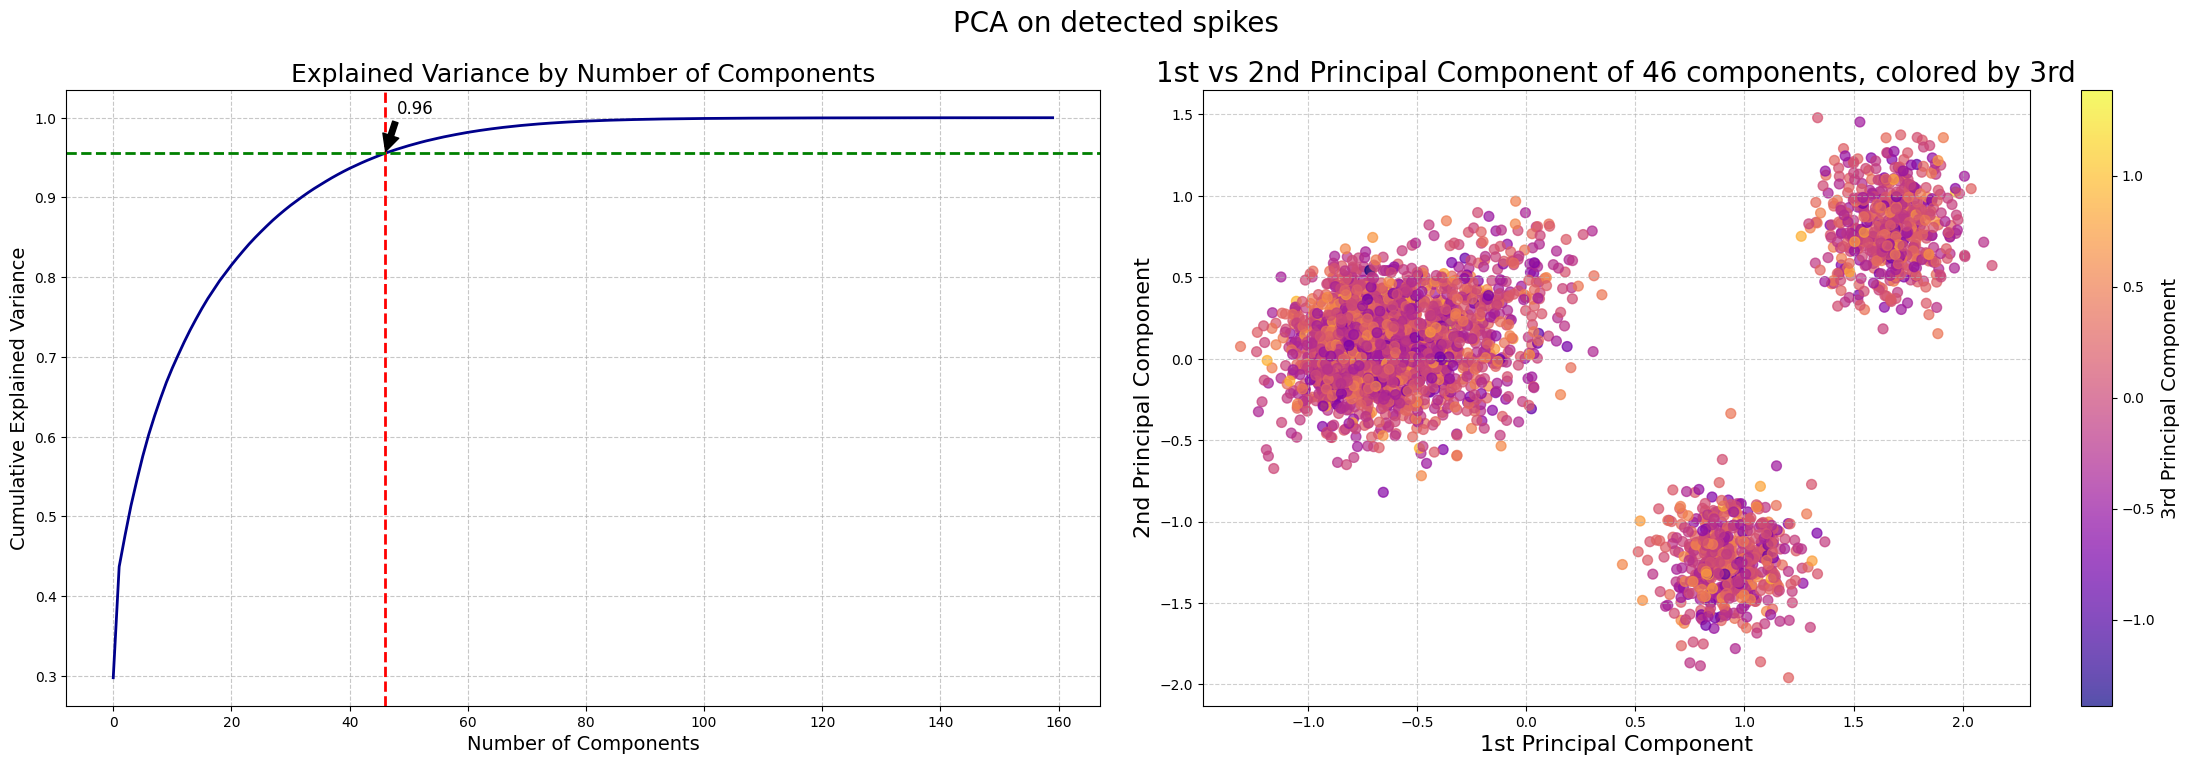

(3271, 46)
46
(3271, 160)


In [15]:
# Extracted data
n_components, pca_result = pca(dataset_scaled, name="detected")

print(pca_result.shape)
print(n_components)
print(dataset_scaled.shape)

## K-means

In [16]:
from sklearn.decomposition import PCA

def k_means(data, num_clus=3, steps=200):
    # Convert data to Numpy array
    cluster_data = np.array(data)

    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)
    center_init = cluster_data[center_init, :]

    # print(center_init.shape)

    rest_num = (data.shape[1] - 2)
    initial_centers = np.array([ [-0.8, 0.2] + [0] * rest_num, [0.8, -1.2] + [0] * rest_num, [1.7, 0.75] + [0] * rest_num ])
    center_init = initial_centers

    cluster = None
    distance = None

    # Repeat clustering for given step amount
    for _ in range(steps):
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))
            tmp_distance += np.abs(np.random.randn(len(tmp_distance)) * 0.0001)
            distance.append(tmp_distance)

        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))
        center_init = [cluster_data[cluster == i, :].mean(axis=0).tolist() for i in range(num_clus)]

    return cluster, center_init, distance

def confusion_matrix_cal(true_cluster, pred_cluster, name="real"):
    pred_cluster[np.isnan(pred_cluster)] = 3
    pred_cluster[:30], pred_cluster[-30:] = pred_cluster[-30:], pred_cluster[:30]
    cm = confusion_matrix(true_cluster, pred_cluster)
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.array(np.unique(pred_cluster), dtype=np.int64).tolist(),
                yticklabels=np.array(np.unique(true_cluster), dtype=np.int64).tolist())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix stats of {name} Data")
    plt.plot()

    # print stats: total precision, recall, f1 score
    precision = np.sum(np.diag(cm)) / np.sum(cm)
    recall = np.sum(np.diag(cm)) / np.sum(cm)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1 score: {}'.format(f1_score))

def k_means_plot(data_pca, spike_cluster, wave_form_k_means, centers, num_clus, name):
    # Stylish and modern color palette updated with purple and orange
    colors = ['#d62728', '#800080', '#FFA500']  # Red, Purple, Orange

    # Assign colors to clusters correctly
    color_cluster = np.array([colors[x] for x in spike_cluster])

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Clustered Data Scatter Plot
    scatter = ax[0].scatter(data_pca[:, 0], data_pca[:, 1], c=color_cluster, s=50, alpha=0.7)
    ax[0].scatter(np.array(centers)[:, 0], np.array(centers)[:, 1], c='black', marker='x', s=100, label='Centroids')
    ax[0].set_xlabel('1st Principal Component', fontsize=16)
    ax[0].set_ylabel('2nd Principal Component', fontsize=16)
    ax[0].set_title('Clustered Data', fontsize=20)
    ax[0].legend(fontsize=12)
    ax[0].grid(True, linestyle='--', alpha=0.3)

    print(spike_cluster.shape)
    print(wave_form_k_means.shape)

    # Average Waveform Plot
    time = np.linspace(0, wave_form_k_means.shape[1]/rate, wave_form_k_means.shape[1]) * 1000
    for i in range(num_clus):
        cluster_mean = wave_form_k_means[spike_cluster == i, :].mean(axis=0)
        cluster_std = wave_form_k_means[spike_cluster == i, :].std(axis=0)

        ax[1].plot(time, cluster_mean, label=f'Cluster {i}', color=colors[i], linewidth=2)
        ax[1].fill_between(time, cluster_mean - cluster_std, cluster_mean + cluster_std, color=colors[i], alpha=0.25)

    ax[1].set_title('Average Waveforms per Cluster', fontsize=20)
    ax[1].set_xlim([0, time[-1]])
    ax[1].set_xlabel('Time [ms]', fontsize=16)
    ax[1].set_ylabel('Amplitude [uV]', fontsize=16)
    ax[1].legend(fontsize=12)
    ax[1].grid(True, linestyle='--', alpha=0.3)

    fig.suptitle(f"Spike classification on {name} spikes", fontsize=20)

    plt.tight_layout()
    plt.show()

def k_means_total(data_pca, wave_form_k_means, num_clus=3, steps=200, name="real"):
    # Clustering of data
    num_clus = 3
    spike_cluster, centers, _ = k_means(data_pca, num_clus, steps)

    k_means_plot(data_pca, spike_cluster, wave_form_k_means, centers, num_clus, name)

    return spike_cluster, centers

(3214,)
(3214, 160)


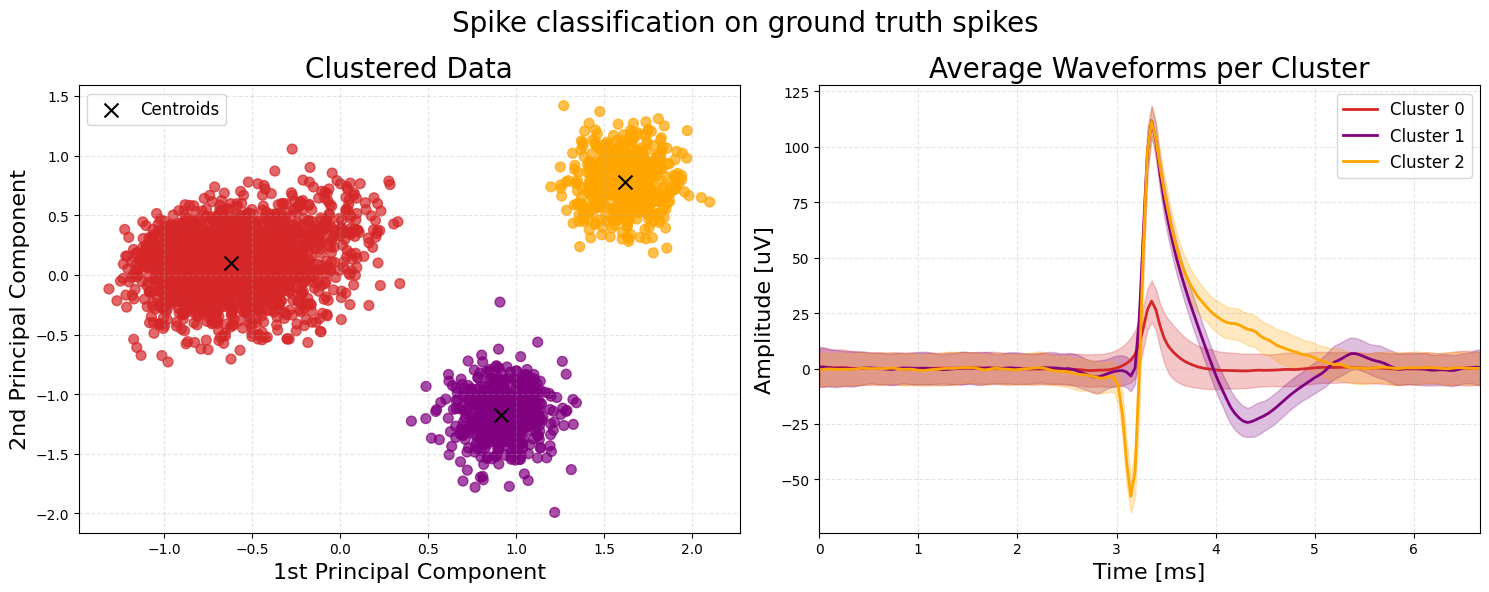

In [17]:
spike_cluster_real, _ = k_means_total(pca_result_real, real_waveform,
              num_clus=3, steps=20, name="ground truth")

(3271,)
(3271, 160)


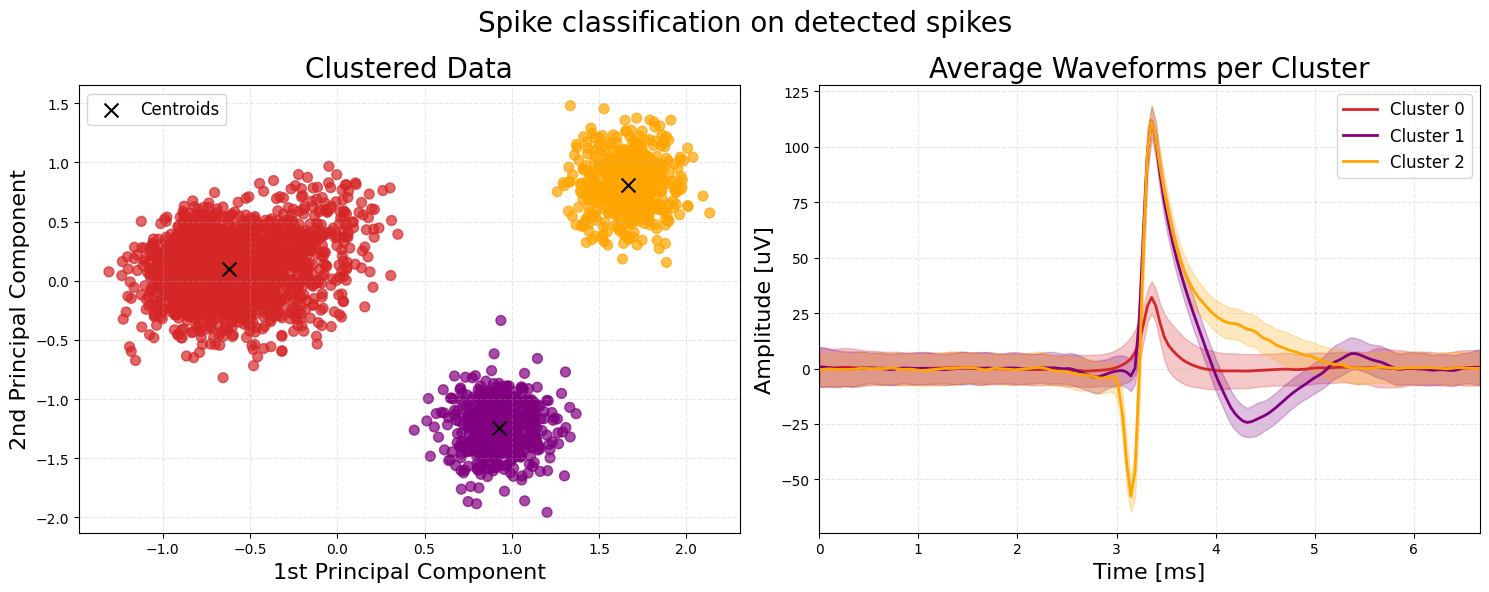

In [18]:
spike_cluster, _ = k_means_total(pca_result, wave_form,
              num_clus=3, steps=20, name="detected")

# Evaluation

## Spike detection

In [19]:
# Find how many extracted spikes are actually included in ground truth
table_spikes_found=[]
table_predicted_cluster=[]

for i in range(len(true_spike_samp)):    #For each sample in ground truth
    peak_found = False

    #Itereate over the next 45 consecutive samples and detect if match with spikes extracted exists
    for j in range(true_spike_samp[i],true_spike_samp[i]+40):
        if j in spike_samp:
            table_spikes_found = np.append(table_spikes_found, j)
            table_predicted_cluster = np.append(table_predicted_cluster,spike_cluster[spike_samp == j])
            peak_found = True
            break

    if peak_found == False:
        table_spikes_found = np.append(table_spikes_found, np.NaN)
        table_predicted_cluster = np.append(table_predicted_cluster,np.NaN)

# Percentage of ground truth spikes detected
precision = len(table_spikes_found[~np.isnan(table_spikes_found)])/len(true_spike_samp)
precision = np.round(precision*100,2)

recall = len(table_spikes_found[~np.isnan(table_spikes_found)])/len(spike_samp)
recall = np.round(recall*100,2)

f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = np.round(f1_score,2)

print('{} % of spikes in ground truth were found (PRECISION)'.format(precision))
print('{} % of spikes detected are in the ground truth (RECALL)'.format(recall))
print('F1 score: {}'.format(f1_score))

79.96 % of spikes in ground truth were found (PRECISION)
78.57 % of spikes detected are in the ground truth (RECALL)
F1 score: 79.26


In [20]:
# precision by class

for class_id in np.arange(0, 3):
    mask = (true_spike_cluster == class_id) & (~np.isnan(table_predicted_cluster))
    class_detected_TP = np.sum(table_predicted_cluster[mask] == class_id)
    class_total_truth = np.sum(true_spike_cluster == class_id)
    class_precision = class_detected_TP / class_total_truth * 100
    class_precision = np.round(class_precision, 2)
    class_true_cluster = true_spike_cluster[true_spike_cluster == class_id]

    print(f"Precision for class {class_id}: {class_precision:.2f}")
    print(f"Total spikes in class {class_id}: {len(class_true_cluster)}")
    print(f"Detected spikes in class {class_id}: {class_detected_TP}")
    print("----------------------------------------------------")

Precision for class 0: 70.18
Total spikes in class 0: 2156
Detected spikes in class 0: 1513
----------------------------------------------------
Precision for class 1: 99.81
Total spikes in class 1: 529
Detected spikes in class 1: 528
----------------------------------------------------
Precision for class 2: 100.00
Total spikes in class 2: 529
Detected spikes in class 2: 529
----------------------------------------------------


## Spike classification

Precision: 0.7955818294959552
Recall: 0.7955818294959552
F1 score: 0.7955818294959552


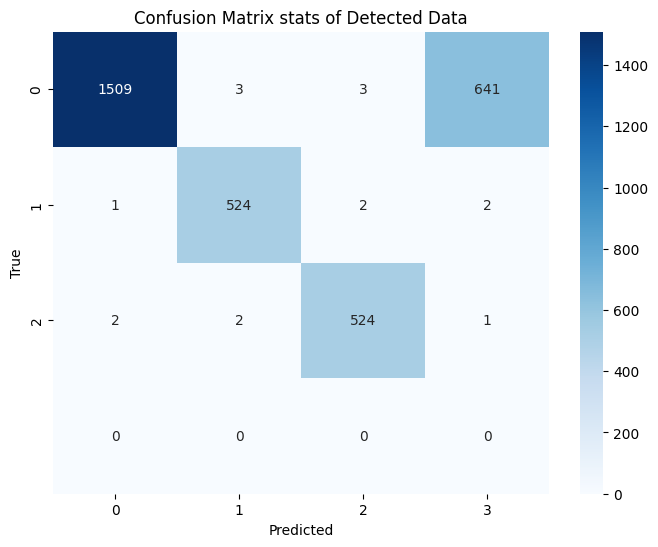

In [21]:
confusion_matrix_cal(true_spike_cluster, table_predicted_cluster, name="Detected")

Precision: 0.9953329184816428
Recall: 0.9953329184816428
F1 score: 0.9953329184816428


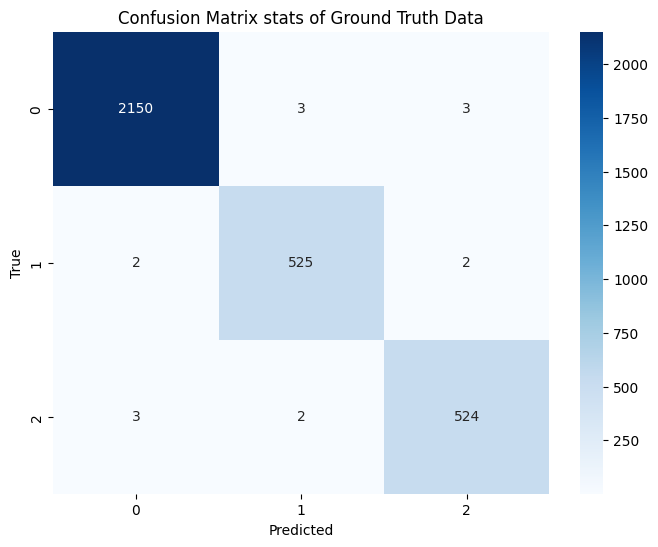

In [22]:
confusion_matrix_cal(true_spike_cluster, spike_cluster_real, name="Ground Truth")